If you're dealing with a classification problem, you should use SVC in scikit-learn for building your Support Vector Machine model. Here's a step-by-step guide:

# SVM (support vector machine)

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv('08notsmote_FEAUTURES.csv')
df = pd.read_csv('10ma_FEAUTURES.csv')
df.head()

,Appetite(MA3),pEffort(MA3),Sex_F,SleepInd(MA3),uaI(MA3),DeltaWt (%)(MA3),FatigInd
0,5.193648,5.260414,1,-4.975425,2.240202,-0.003578,Optimal
1,6.000000,3.230228,1,-6.265990,1.999969,0.000167,Optimal
2,5.537896,2.991013,0,-3.682606,0.780255,0.000021,Optimal
3,6.000000,5.038346,1,-5.825337,2.431632,-0.000004,Optimal
4,6.003911,7.190867,1,-5.477133,1.967599,-0.003108,Optimal


In [26]:
X = df.drop(columns=["FatigInd"])
y = df["FatigInd"]

# standartizar os dados e separar treino de teste

In [27]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=76367843)
X_train.shape, X_test.shape

((511, 6), (128, 6))

## modelo base

The x value that maximizes kf is: 0.7


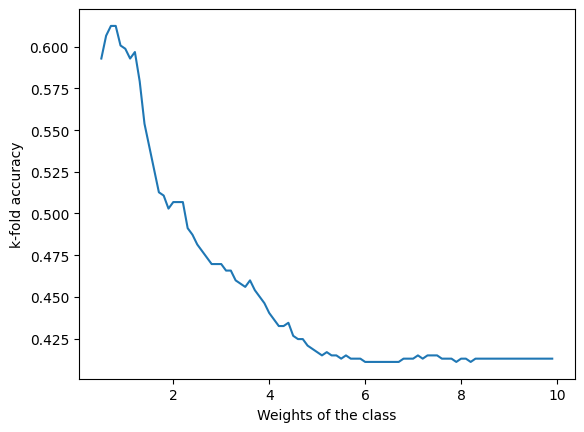

In [28]:
kf = []
weights = np.arange(0.5, 10, 0.1)
for wOP in weights:
    class_weights = {"Low/Minimal": 1, "Optimal": wOP, 'Risk/Caution': 1}  # Increase weight for Class 2
    svc = SVC(class_weight=class_weights)
    scores = cross_val_score(svc, X_train, y_train, cv=7, scoring='accuracy')
    kf.append(scores.mean())
plt.plot(weights, kf)
plt.xlabel('Weights of the class')
plt.ylabel('k-fold accuracy')

max_index = np.argmax(kf)

# Find the corresponding x value
x_max = weights[max_index]

print("The x value that maximizes kf is:", x_max)

In [29]:
# Define parameter distribution
param_dist = {
    'C': np.logspace(-3, 3, 7),  # Regularization parameter (log scale)
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Include sigmoid kernel
    'degree': [2, 3, 4],  # Degree for polynomial kernel (only useful for 'poly')
    'coef0': np.linspace(-2, 5, 3)  # Independent term in kernel
}

# Initialize the SVC model
#class_weights = {"Low/Minimal": 1, "Optimal": 1, 'Risk/Caution': 1}  # Increase weight for Class 2
#svc = SVC(class_weight=class_weights)

svc = SVC()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(svc, param_distributions=param_dist, 
                                   n_iter=500, cv=7, scoring='accuracy', 
                                   random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)
print("Best parameters found: ", random_search.best_params_)

KeyboardInterrupt: 

In [ ]:
best_svc = random_search.best_estimator_
best_svc.fit(X_train, y_train)

SVC(C=np.float64(10.0),
    class_weight={'Low/Minimal': 1, 'Optimal': 1, 'Risk/Caution': 1}, coef0=0.1,
    gamma=0.1, kernel='poly')

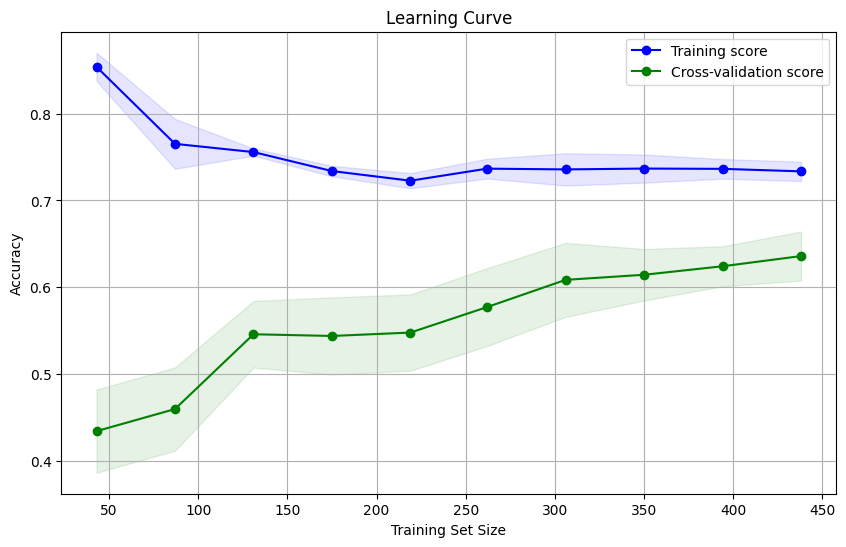

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    best_svc, X_train, y_train, cv=7, scoring='accuracy', n_jobs=-1
)

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_svc, X_train, y_train, cv=7, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score", color="green")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()



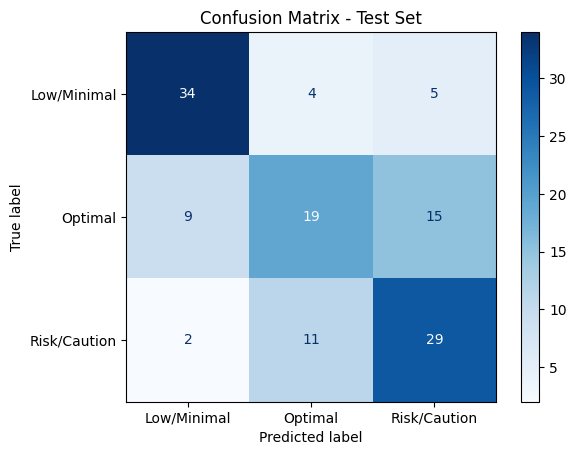

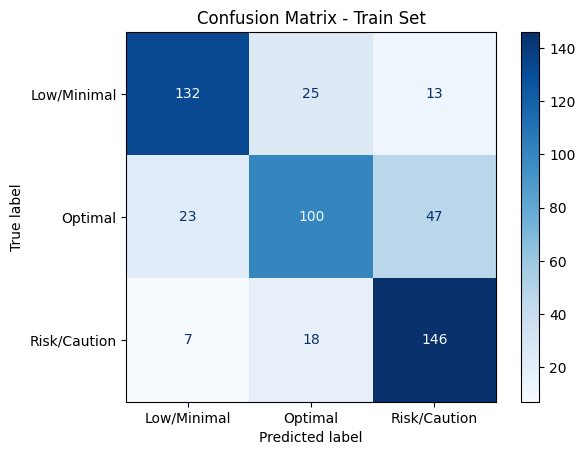

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
y_pred_test = best_svc.predict(X_test)

# Generate the confusion matrix for the test set
cm_test = confusion_matrix(y_test, y_pred_test)

# Display the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=best_svc.classes_)
disp_test.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Optionally, you can also generate confusion matrix for the training set
y_pred_train = best_svc.predict(X_train)

# Generate the confusion matrix for the train set
cm_train = confusion_matrix(y_train, y_pred_train)

# Display the confusion matrix for the train set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=best_svc.classes_)
disp_train.plot(cmap="Blues")
plt.title("Confusion Matrix - Train Set")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

y_pred_test = best_svc.predict(X_test)
report = classification_report(y_test, y_pred_test)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

 Low/Minimal       0.76      0.79      0.77        43
     Optimal       0.56      0.44      0.49        43
Risk/Caution       0.59      0.69      0.64        42

    accuracy                           0.64       128
   macro avg       0.64      0.64      0.63       128
weighted avg       0.64      0.64      0.63       128



In [ ]:
y_pred_train = best_svc.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

 Low/Minimal       0.81      0.78      0.80       170
     Optimal       0.70      0.59      0.64       170
Risk/Caution       0.71      0.85      0.77       171

    accuracy                           0.74       511
   macro avg       0.74      0.74      0.74       511
weighted avg       0.74      0.74      0.74       511

